## Imports

In [ ]:
!pip install statsmodels
!pip install xgboost lightgbm scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import gc
from multiprocessing import Process

import os


In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Functions

In [3]:
def draw_plots(df, column):
    df.index = pd.to_datetime(df.index)

    plt.figure(figsize=(12, 8))
    plt.plot(df.index, df[column])

    plt.show()

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
def get_trends(df, column, period = 12, typee = "additive"):
  a_decomposition = seasonal_decompose(df[column], model = typee, period = period)
  trend = a_decomposition.trend
  seasonal = a_decomposition.seasonal
  residual = a_decomposition.resid

  trend = trend.dropna()
  seasonal = seasonal.dropna()  
  residual = residual.dropna()

  return trend, seasonal, residual

def plot_trends(trend, seasonal, residual, period=None, downsample=100, save_path=None):
    """
    Plots trend, seasonal, and residual components with improved aesthetics and performance.

    Args:
        trend (pd.Series): The trend component.
        seasonal (pd.Series): The seasonal component.
        residual (pd.Series): The residual component.
        period (int, optional): Period used for decomposition. If set, vertical lines will be drawn.
        downsample (int, optional): Plot every nth point for speed.
        save_path (str, optional): Path to save the plot.
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))

    # Downsample and drop NaNs for plotting
    trend_plot = trend.dropna()[::downsample]
    seasonal_plot = seasonal.dropna()[::downsample]
    residual_plot = residual.dropna()[::downsample]

    # Plot Trend
    plt.subplot(3, 1, 1)
    sns.lineplot(data=trend_plot)
    plt.title("Trend Component", fontsize=14)
    plt.ylabel("Value")
    plt.xlabel("")
    if period:
        for i in range(0, len(trend_plot), period // downsample):
            plt.axvline(x=trend_plot.index[i], color='gray', linestyle='--', alpha=0.2)

    # Plot Seasonal
    plt.subplot(3, 1, 2)
    sns.lineplot(data=seasonal_plot)
    plt.title("Seasonal Component", fontsize=14)
    plt.ylabel("Value")
    plt.xlabel("")
    if period:
        for i in range(0, len(seasonal_plot), period // downsample):
            plt.axvline(x=seasonal_plot.index[i], color='gray', linestyle='--', alpha=0.2)

    # Plot Residual
    plt.subplot(3, 1, 3)
    sns.lineplot(data=residual_plot)
    plt.title("Residual Component", fontsize=14)
    plt.ylabel("Value")
    plt.xlabel("Time")
    if period:
        for i in range(0, len(residual_plot), period // downsample):
            plt.axvline(x=residual_plot.index[i], color='gray', linestyle='--', alpha=0.2)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [5]:
def plot_distribution(df, columns, type = "hist",nrows = 2, ncols = 2, save_path = ""):

    if(type == "heatmap"):
        plt.figure(figsize=(20, 10))
        sns.heatmap(
                    df[columns].corr(),
                    cmap="coolwarm",
                    annot=True,
                    fmt=".2f",
                    square=True,
                    linewidths=0.5,
                    cbar_kws={"shrink": 0.8},
                    annot_kws={"size": 12}
                )
        plt.title(f"Correlation Heatmap", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(fontsize=12)
        if(save_path):
            plt.savefig(f"./figures/{save_path}.png", dpi = 300)
        plt.show()
        return
    

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))
    axes_flat = ax.flatten()


    for i, column in enumerate(columns):
        if(type == "heatmap"):
            continue
        current_ax = axes_flat[i]

        if(type == "hist"):
            current_ax.hist(df[column],bins = 'auto')
            current_ax.set_xlabel(f"{column}")
            current_ax.set_ylabel("Occurences")
        if(type == "box"):
            current_ax.boxplot(df[column])
            current_ax.set_xlabel(f"{column}")

        if(type == "bar"):
            value_counts = df[column].value_counts().sort_index()
            current_ax.bar(value_counts.index.astype(str), value_counts.values)
            current_ax.set_xlabel(f"{column}")
            current_ax.set_ylabel("Count")

        current_ax.set_title(f"Distribution of {column}")
        current_ax.grid(True, linestyle='--', alpha=0.6)
            

    for i in range(len(columns), len(axes_flat)):
        axes_flat[i].set_visible(False)
        
    if(save_path):
        plt.savefig(f"./figures/{save_path}.png", dpi = 300)

    plt.show()

## Main Code

In [22]:
df = pd.read_csv('./telemetry_data_v3.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.drop("device_name", axis = 1, inplace=True)
df.shape

(1592910, 2)

In [7]:
print(df.isnull().sum())
print("===============")
print(df.dtypes)

property    0
Value       0
dtype: int64
property     object
Value       float64
dtype: object


In [8]:
df.head()

,property,Value
Timestamp,,
2025-06-01 16:00:00.051425+00:00,co2_reading,611.332214
2025-06-01 16:00:01.096975+00:00,co2_reading,611.332214
2025-06-01 16:00:02.349265+00:00,co2_reading,611.801636
2025-06-01 16:00:03.394221+00:00,co2_reading,611.801636
2025-06-01 16:00:04.438726+00:00,co2_reading,611.801636


In [9]:
co2_reading = df[df.property == "co2_reading"].sort_index()
temperature_reading = df[df.property == "temperature_reading"].sort_index()

In [10]:
co2_reading.drop("property", axis = 1, inplace=True)
temperature_reading.drop("property", axis = 1, inplace=True)

co2_reading.rename(columns={"Value": "co2_reading"}, inplace=True)
temperature_reading.rename(columns={"Value": "temperature_reading"}, inplace=True)

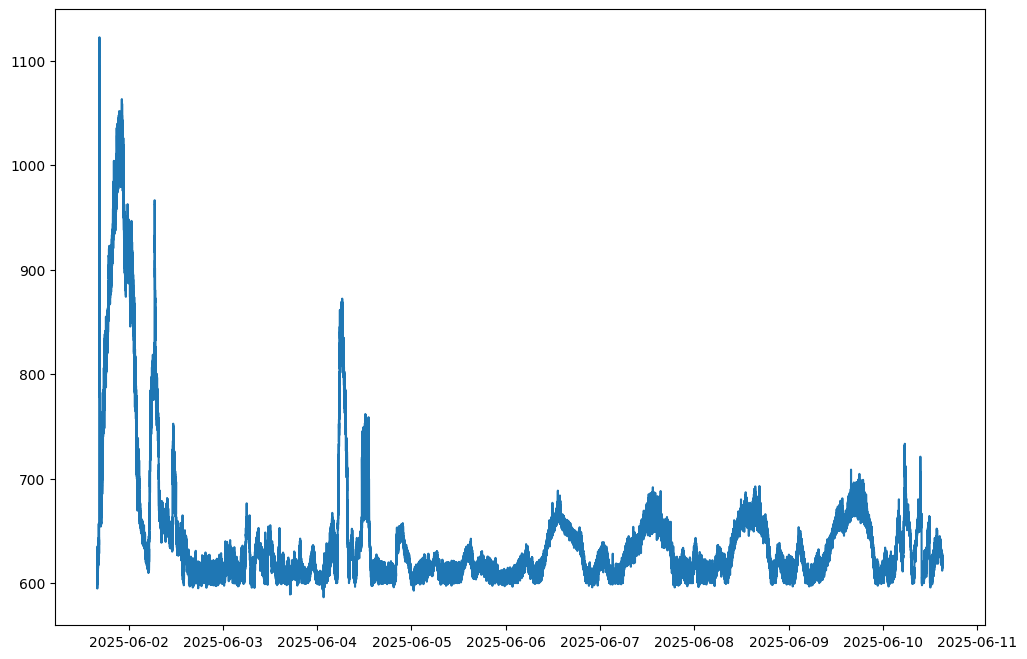

In [14]:
draw_plots(co2_reading,"co2_reading")

In [15]:
df.shape

(1592910, 2)

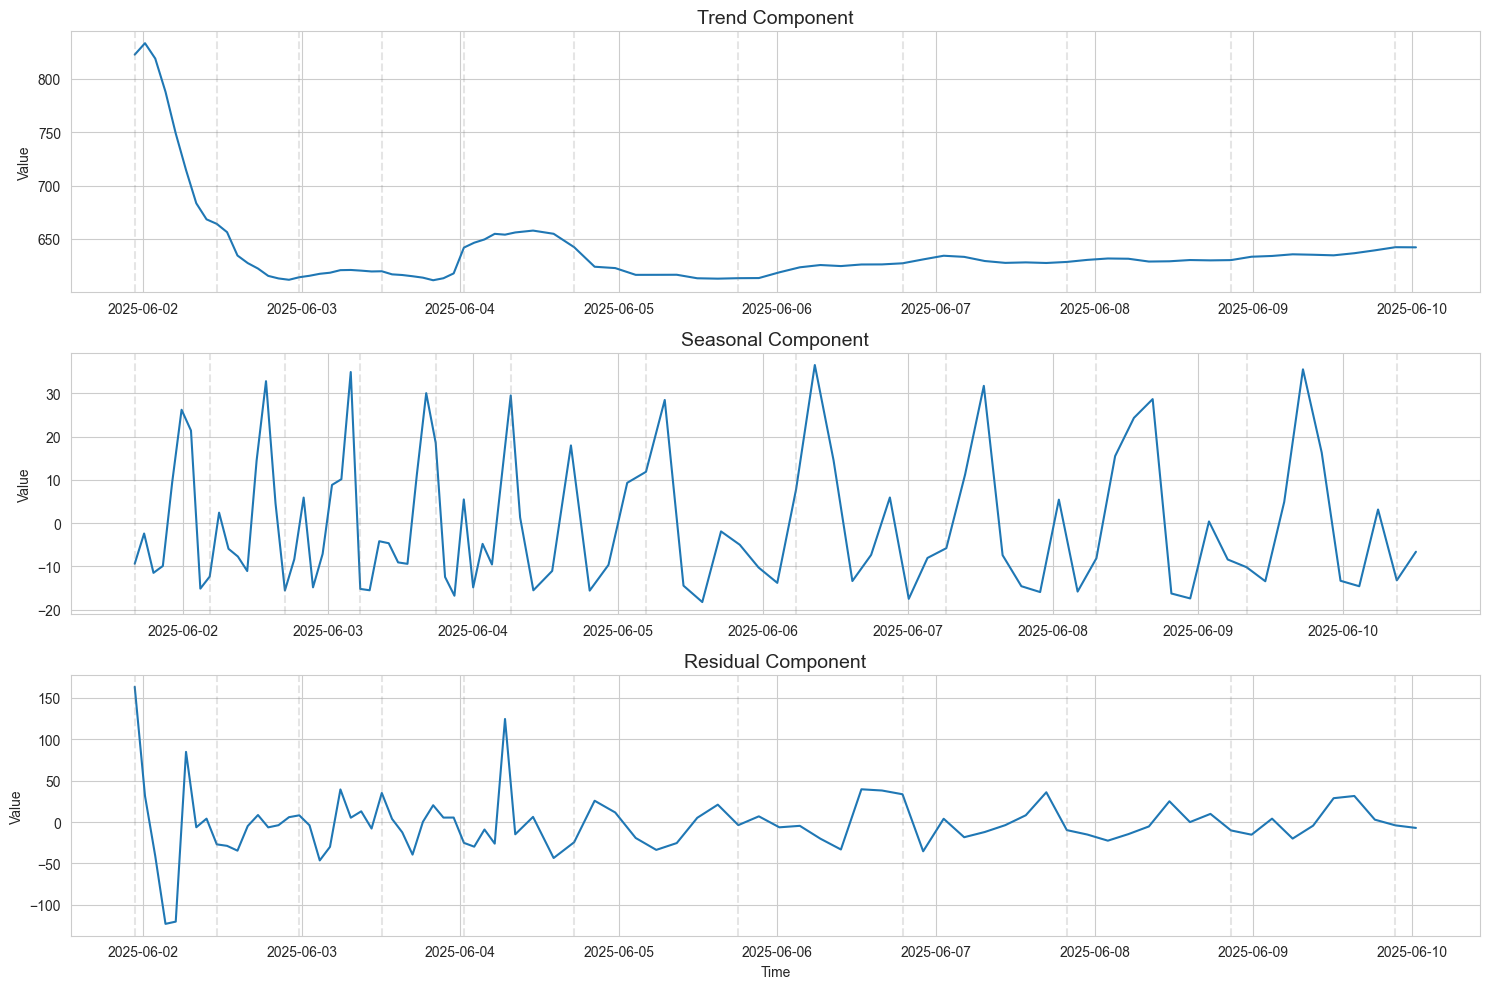

In [ ]:
# Define the number of seconds in a day, hour, and minute
daily_cycle = 60 * 60 * 24
hourly_cycle = 60 * 60
minute_cycle = 60

# Decompose the CO2 time series into trend, seasonal, and residual components
trend, seasonal, residual = get_trends(co2_reading, "co2_reading", period=daily_cycle, typee="additive")

# Plot and save the trend, seasonal, and residual components to a PNG file
plot_trends(trend, seasonal, residual, period=daily_cycle, downsample=10000, save_path="./figures/co2_trends.png")

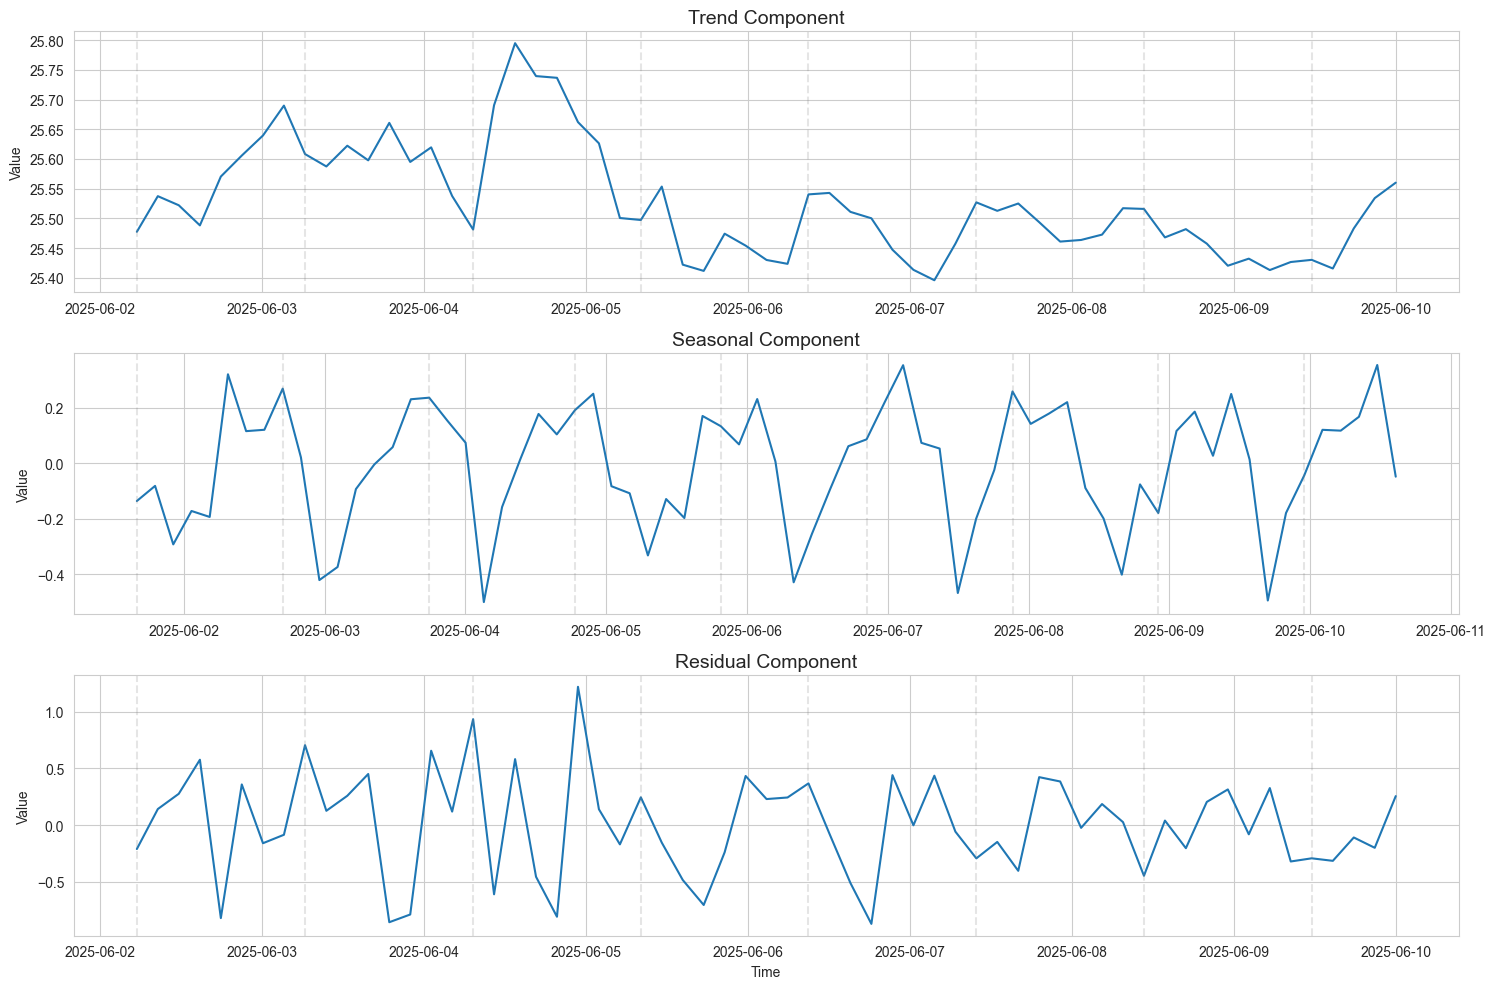

In [ ]:
trend, seasonal, residual = get_trends(temperature_reading, "temperature_reading", period = daily_cycle, typee = "additive")

plot_trends(trend, seasonal, residual, period=daily_cycle, downsample=10000, save_path="figures/temperature_trends.png")


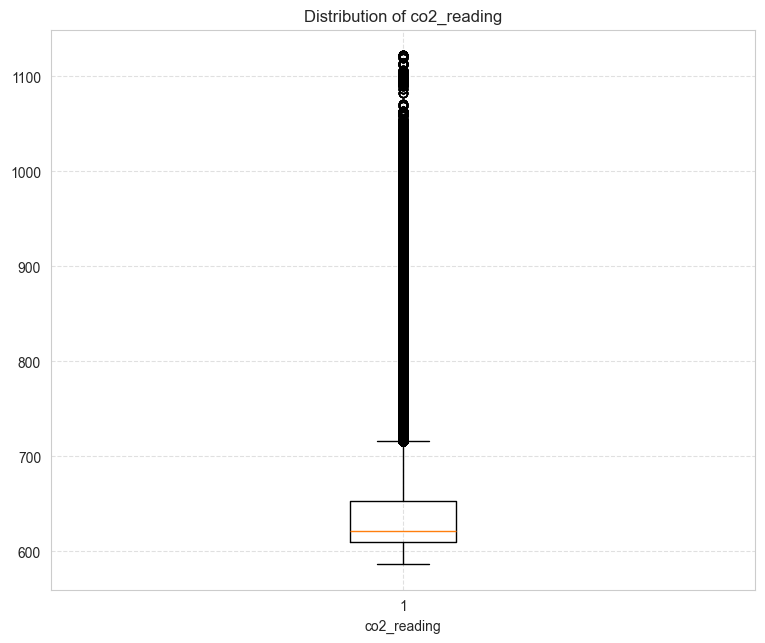

In [ ]:
plot_distribution(co2_reading, ["co2_reading"], type = "box",nrows = 2, ncols = 2, save_path = "")

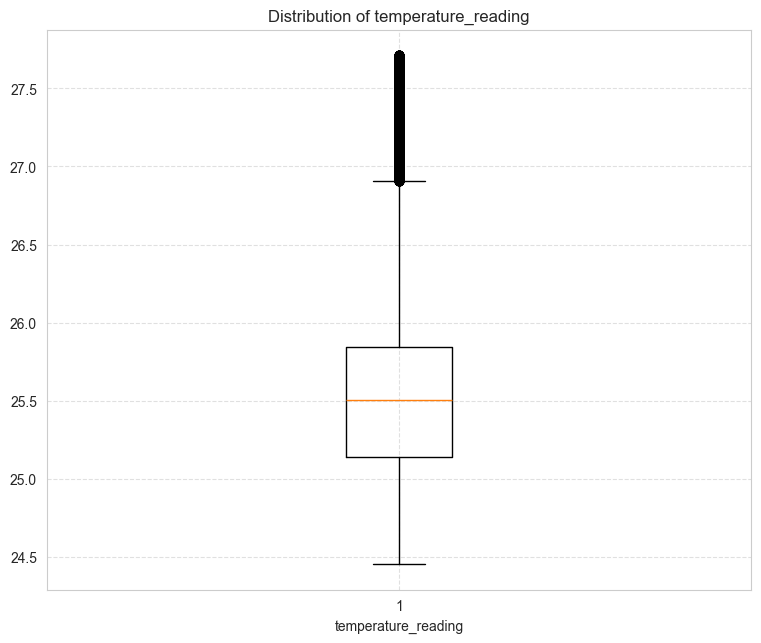

In [ ]:
plot_distribution(temperature_reading, ["temperature_reading"], type = "box",nrows = 2, ncols = 2, save_path = "")

In [11]:
def winsorize_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    """
    Winsorizes the outliers in a specified column of a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column to winsorize.
        lower_quantile (float): The lower quantile threshold (default is 0.01).
        upper_quantile (float): The upper quantile threshold (default is 0.99).
    
    Returns:
        pd.DataFrame: The DataFrame with winsorized values in the specified column.
    """
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df


def remove_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    """
    Removes outliers from a specified column of a DataFrame based on quantiles.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column to remove outliers from.
        lower_quantile (float): The lower quantile threshold (default is 0.01).
        upper_quantile (float): The upper quantile threshold (default is 0.99).
    
    Returns:
        pd.DataFrame: The DataFrame with outliers removed from the specified column.
    """
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [12]:
co2_reading = remove_outliers(co2_reading, "co2_reading",lower_quantile=0.20, upper_quantile=0.95)
temperature_reading = remove_outliers(temperature_reading, "temperature_reading", lower_quantile=0.05, upper_quantile=0.90)

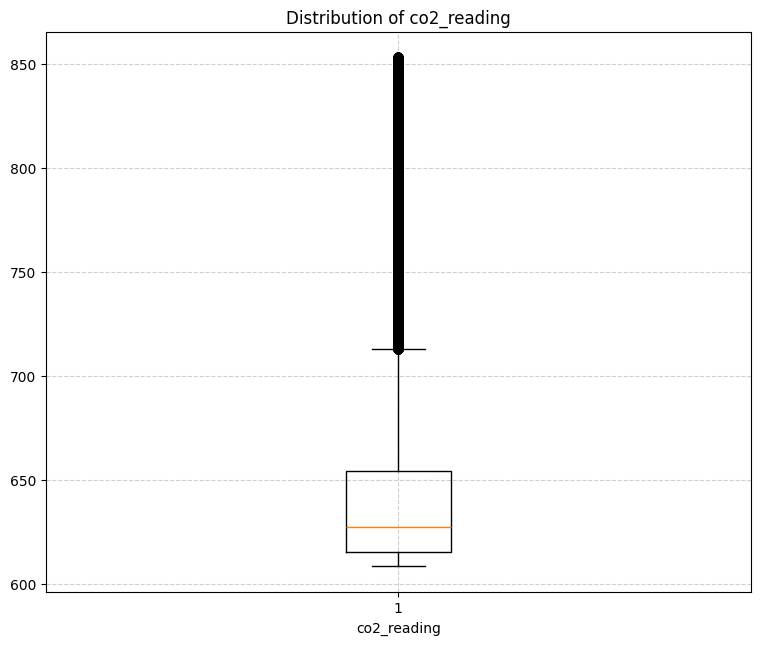

In [76]:
plot_distribution(co2_reading, ["co2_reading"], type = "box",nrows = 2, ncols = 2, save_path = "co2_winsorized")

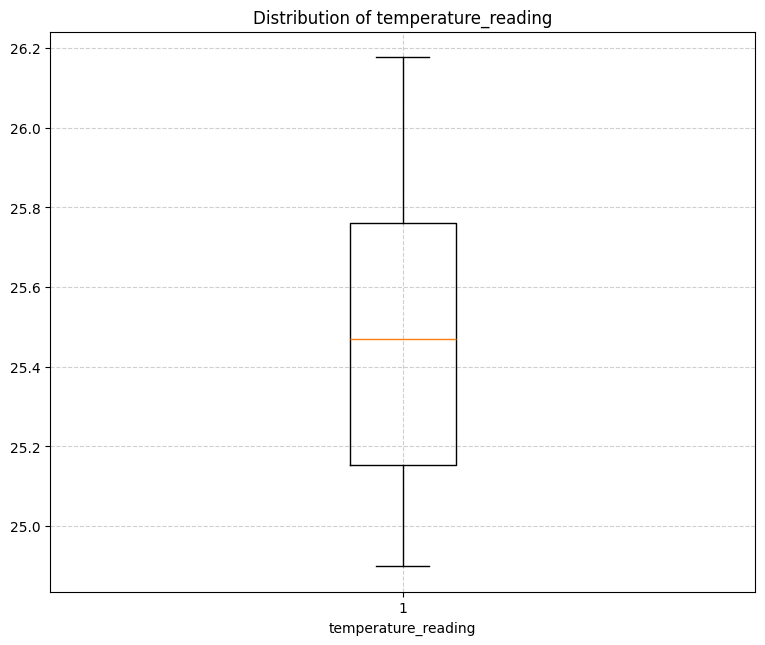

In [77]:
plot_distribution(temperature_reading, ["temperature_reading"], type = "box",nrows = 2, ncols = 2, save_path = "temperature_winsorized")

In [78]:
def plot_rolling_windows(df, column, windows_seconds, time_unit='s', save_path=None):
    """
    Applies multiple rolling windows to a column and plots them side by side.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index.
        column (str): Name of the column to smooth.
        windows_seconds (list): List of window sizes in seconds.
        time_unit (str): Time unit for rolling window (default 's' for seconds).
        save_path (str, optional): If provided, saves the plot to this path.
    """
    plt.figure(figsize=(18, 3 * len(windows_seconds)))
    original = df[column].dropna()
    for i, window in enumerate(windows_seconds):
        smoothed = original.rolling(f'{window}{time_unit}', min_periods=1).mean()
        plt.subplot(len(windows_seconds), 1, i + 1)
        plt.plot(original.index, original, alpha=0.3, label='Original', linewidth=0.7)
        plt.plot(smoothed.index, smoothed, label=f'Rolling Mean ({window//60 if window>=60 else window} {"min" if window>=60 else "sec"})', linewidth=1.5)
        plt.title(f'Rolling Window: {window} seconds')
        plt.ylabel(column)
        plt.legend()
        if i == len(windows_seconds) - 1:
            plt.xlabel('Time')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [15]:
windows = [60, 300, 900, 3600, 10800, 86400]


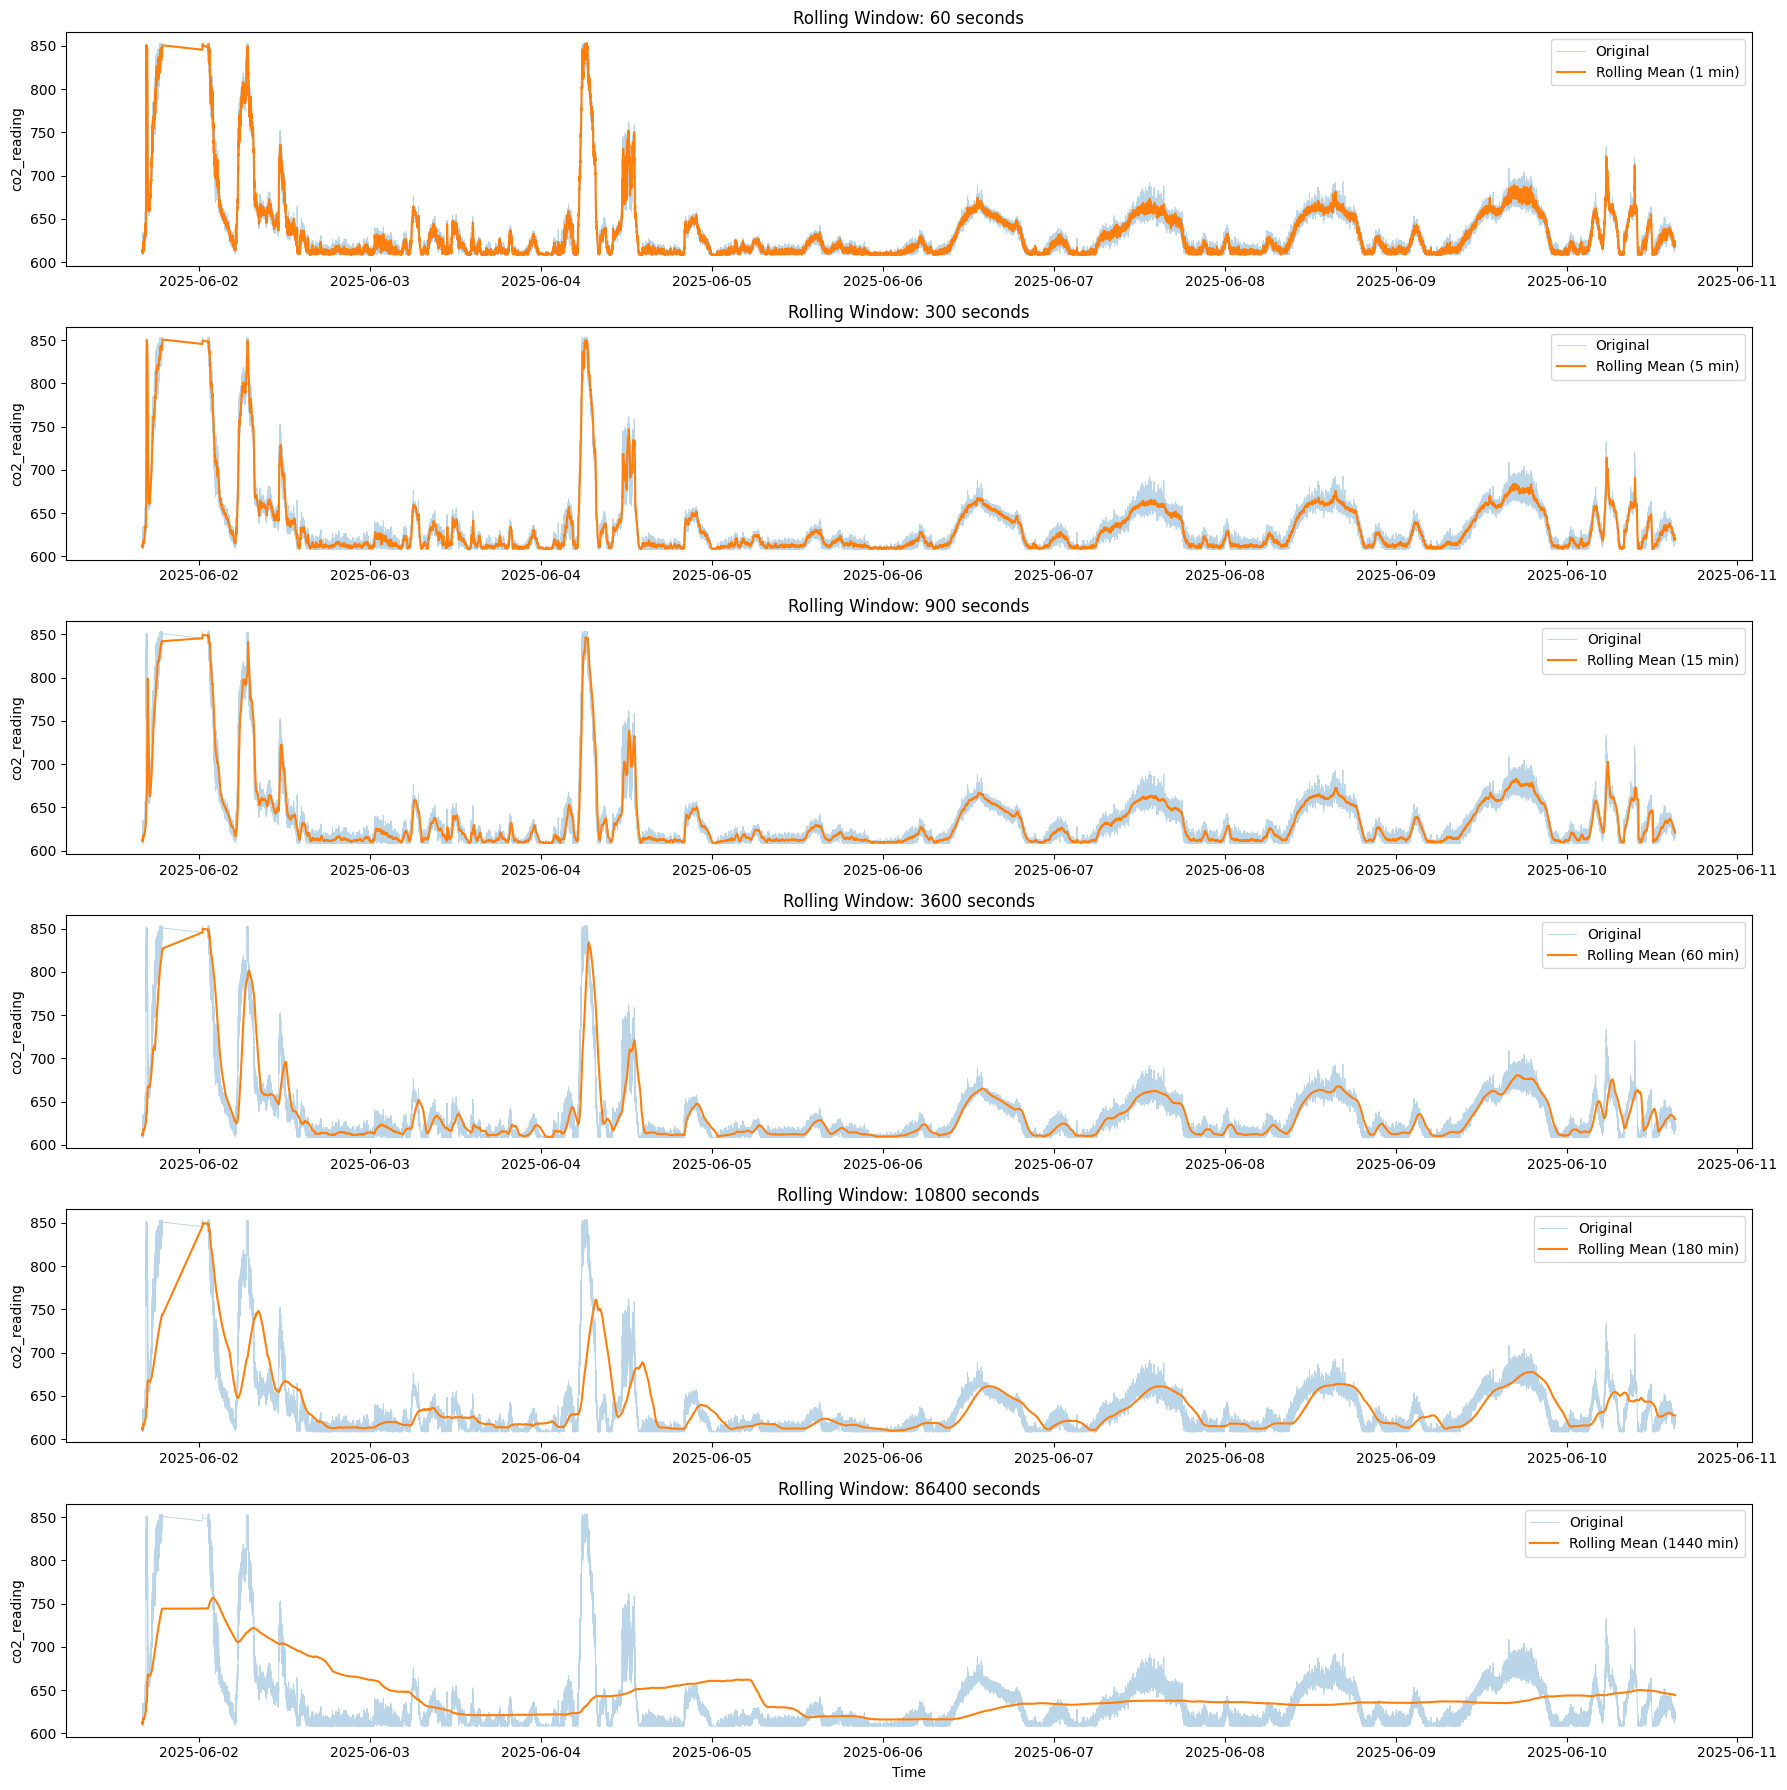

In [80]:
plot_rolling_windows(co2_reading, 'co2_reading', windows_seconds=windows, save_path="./figures/co2_rolling_windows.png")

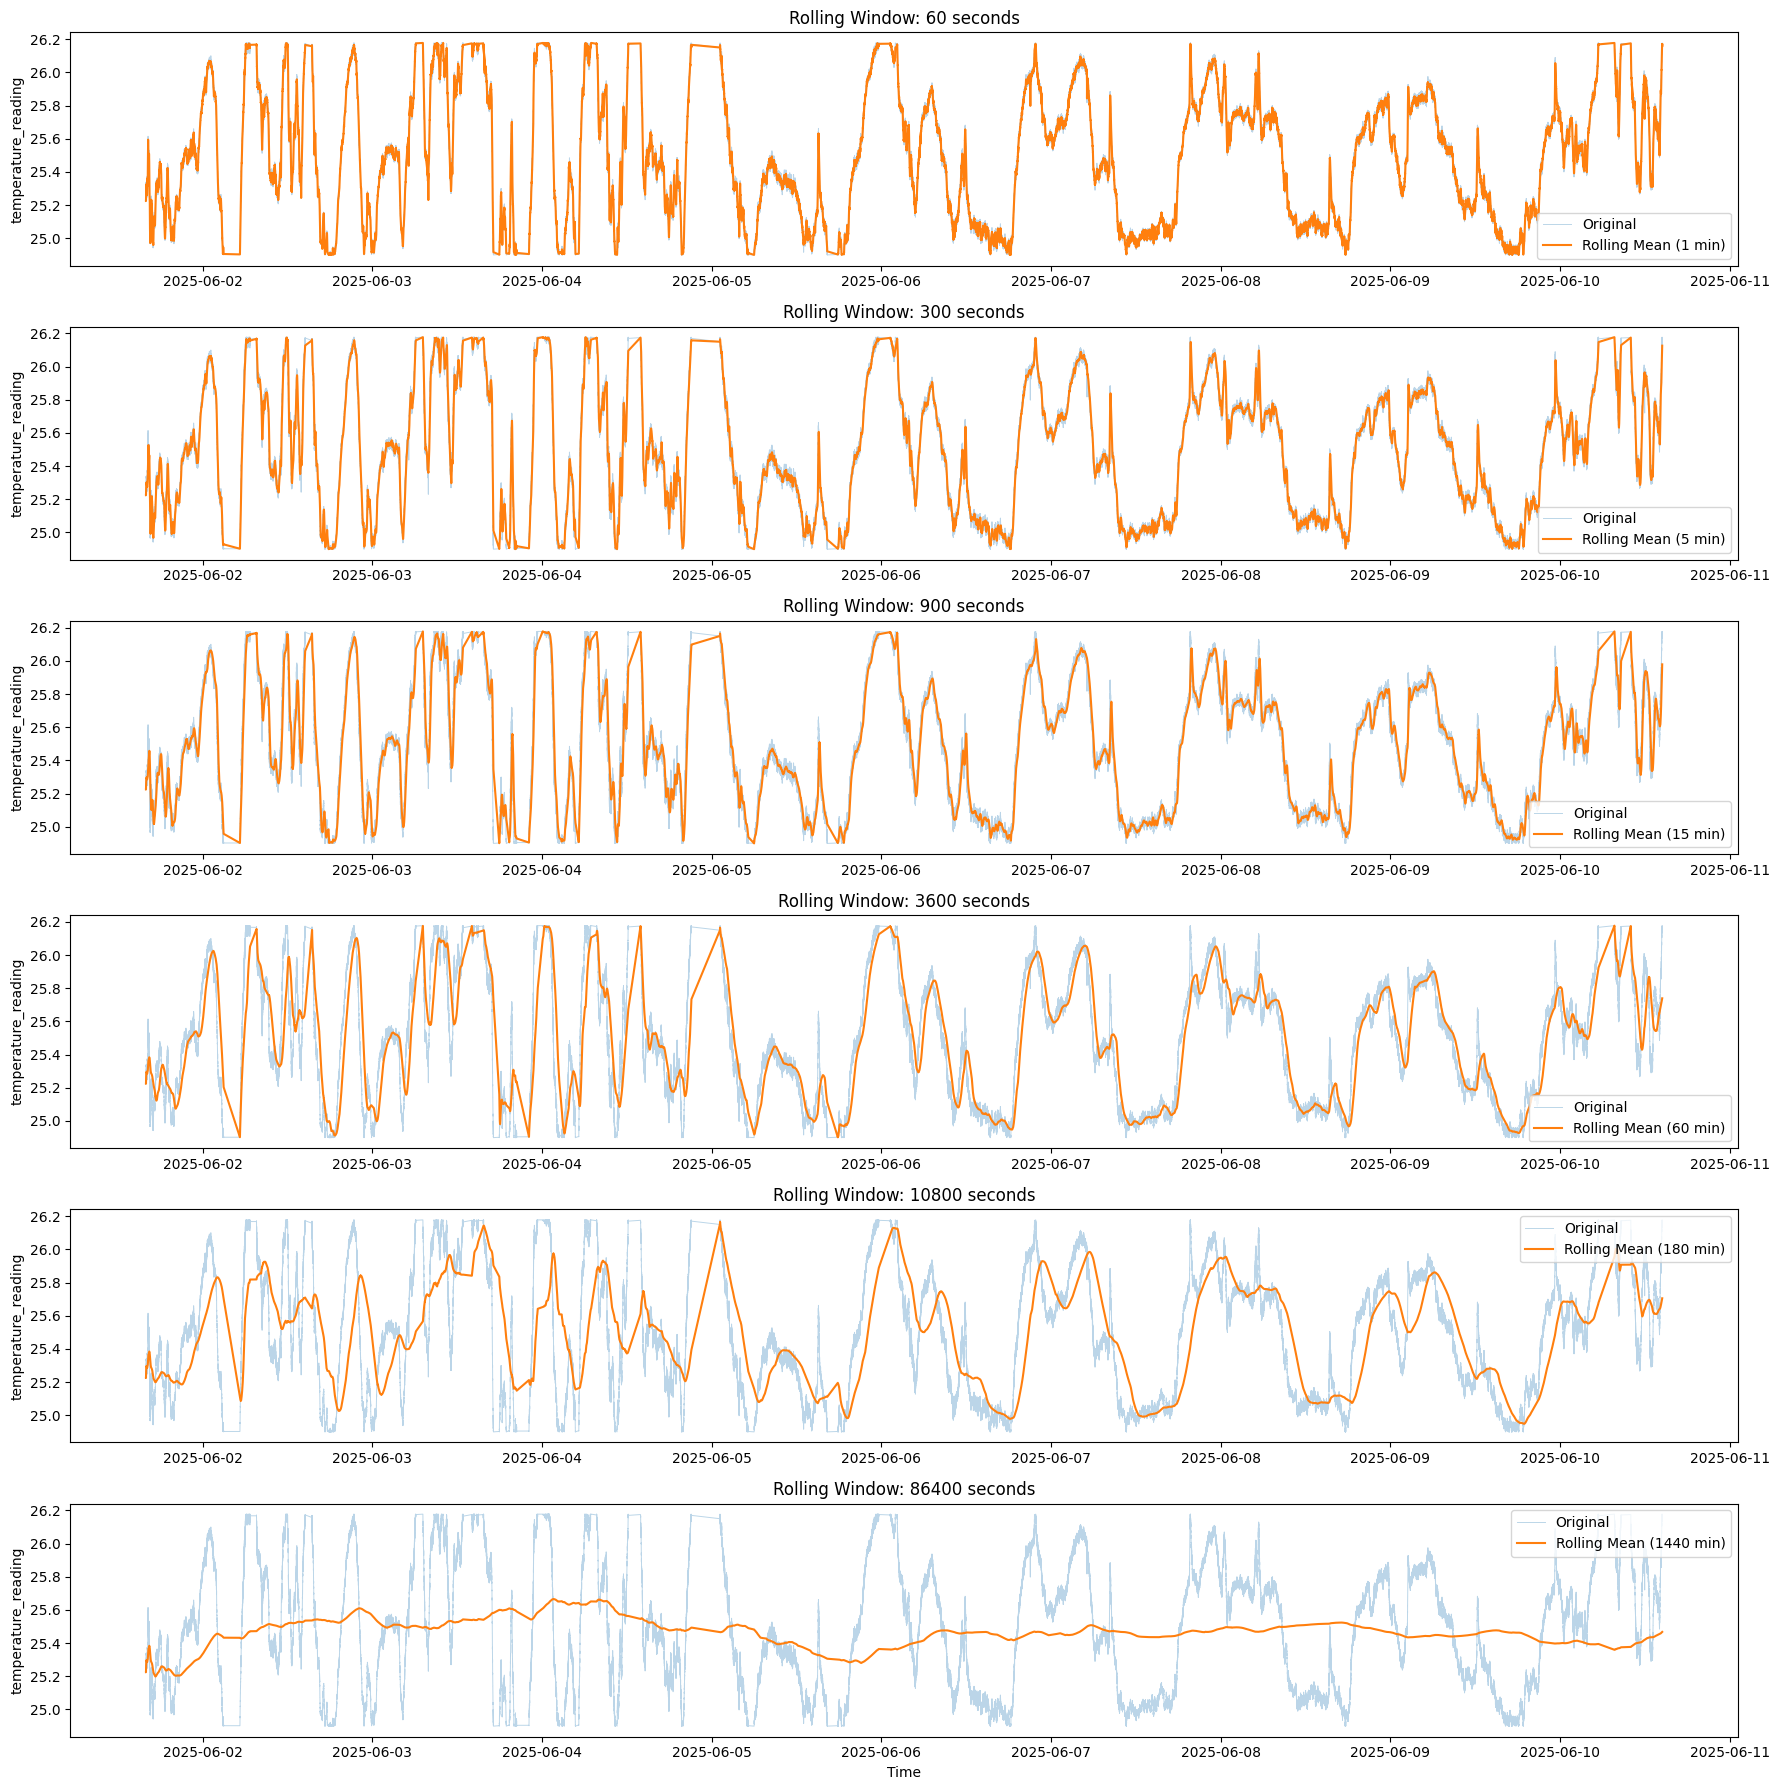

In [81]:
plot_rolling_windows(temperature_reading, 'temperature_reading', windows_seconds=windows, save_path="./figures/temperature_rolling_windows.png")

In [16]:
def calculate_residual_variance(df, column, windows_seconds):
    """
    Calculates the variance of the residuals after applying rolling means.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index.
        column (str): Name of the column to smooth.
        windows_seconds (list): List of window sizes in seconds.

    Returns:
        dict: Dictionary with window sizes as keys and residual variances as values.
    """
    residual_variances = {}
    original = df[column].dropna()
    
    for window in windows_seconds:
        smoothed = original.rolling(f'{window}s', min_periods=1).mean()
        residual = original - smoothed
        residual_variances[window] = np.nanvar(residual)
    
    return residual_variances

def signal_to_noise_ratio(df, column, windows_seconds):
    """
    Calculates the Signal-to-Noise Ratio (SNR) for different rolling windows.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index.
        column (str): Name of the column to analyze.
        windows_seconds (list): List of window sizes in seconds.

    Returns:
        dict: Dictionary with window sizes as keys and SNR values as values.
    """
    snr_values = {}
    original = df[column].dropna()
    
    for window in windows_seconds:
        smoothed = original.rolling(f'{window}s', min_periods=1).mean()
        residual = original - smoothed
        snr = np.nanmean(smoothed) / np.nanstd(residual)
        snr_values[window] = snr
    
    return snr_values

## Lower variance means more smoothing, but too low may hide important changes.



In [83]:
calculate_residual_variance(co2_reading, 'co2_reading', windows_seconds=windows)

{60: np.float64(21.063452673922022),
 300: np.float64(41.4634927247033),
 900: np.float64(110.12501281561377),
 3600: np.float64(474.18804598953625),
 10800: np.float64(1215.0891812531252),
 86400: np.float64(1773.1923722267734)}

In [84]:
calculate_residual_variance(temperature_reading, 'temperature_reading', windows_seconds=windows)

{60: np.float64(0.00016922358874737627),
 300: np.float64(0.0013179753413271932),
 900: np.float64(0.006208249065195589),
 3600: np.float64(0.028972234009719676),
 10800: np.float64(0.07220632171158087),
 86400: np.float64(0.12568532833359233)}

## Higher SNR means the smoothed signal stands out more from the noise.



In [85]:
signal_to_noise_ratio(co2_reading, 'co2_reading', windows_seconds=windows)

{60: np.float64(140.01832839348313),
 300: np.float64(99.80348134098017),
 900: np.float64(61.239591685408435),
 3600: np.float64(29.499066704645703),
 10800: np.float64(18.432551287920163),
 86400: np.float64(15.399927837639263)}

In [86]:
signal_to_noise_ratio(temperature_reading, 'temperature_reading', windows_seconds=windows)

{60: np.float64(1958.4936085217987),
 300: np.float64(701.7732993624296),
 900: np.float64(323.3394494592809),
 3600: np.float64(149.6727911166114),
 10800: np.float64(94.82745827744823),
 86400: np.float64(71.82104112009549)}

## Interpretation
We will choose larger windows because we want to see overall trends.
e.g. 300-second rolling window for CO₂ because it provides a high SNR (74.1) and low residual variance (76.8), balancing noise reduction and event detection.


In [17]:
from statsmodels.tsa.stattools import adfuller

#Perform Dickey-Fuller test:
def test_Dickey_Fuller(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [16]:
def split_data(df, column, train_size=0.8):
    """
    Splits the DataFrame into training and testing sets based on a specified column.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index.
        column (str): Name of the column to split.
        train_size (float): Proportion of the data to use for training (default is 0.8).

    Returns:
        tuple: Training and testing DataFrames.
    """
    n_train = int(len(df) * train_size)
    train = df.iloc[:n_train][[column]]
    test = df.iloc[n_train:][[column]]
    
    return train, test

def train_model(Model, train, column, **kwargs):
    """
    Trains a time series model on the training data.

    Args:
        Model: The time series model class to be trained.
        train (pd.DataFrame): Training DataFrame.
        column (str): Name of the column to train the model on.
        **kwargs: Additional keyword arguments for the model.

    Returns:
        Model instance: The trained model.
    """
    model = Model(train[column], **kwargs)
    results = model.fit()
    
    print(f"Model Summary for {column}:")
    print(results.summary())
    
    return results



import joblib
def train_models(models, train_data, column):
    # add docstring and print statements to see the progress of training as well as the model names
    """    Trains multiple time series models on the provided training data.
    Args:
        models (list): List of dictionaries containing model names, calls, and parameters.
        train_data (pd.DataFrame): Training data with a datetime index.
        column (str): Column name to train the models on.
    Returns:
        dict: Dictionary containing trained models.
    """

    trained_models = {}
    if not isinstance(models, list):
        raise ValueError("The 'models' argument must be a list of dictionaries containing model information.")
    if column not in train_data.columns:
        raise ValueError(f"The column '{column}' is not present in the training data.")
    if train_data.empty:
        raise ValueError("The training data is empty. Please provide valid data for training.")

    for model in models:
        model_name = model["name"]
        model_call = model["call"]
        model_params = model["params"]
        print(f"Preparing to train {model_name} with parameters: {model_params}")
        # Ensure the models directory exists
        if not os.path.exists("./models"):
            os.makedirs("./models")
        if model_name == "SARIMAX":
            trained_model = model_call(train_data[column], **model_params).fit()
            joblib.dump(trained_model, f"./models/{model_name}_{column}_model.pkl")
        elif model_name == "ARIMA":
            trained_model = model_call(train_data[column], **model_params).fit()
            joblib.dump(trained_model, f"./models/{model_name}_{column}_model.pkl")
        else:
            # For other models, we need to reshape the data
            X = np.arange(len(train_data)).reshape(-1, 1)  # Time as feature
            y = train_data[column].values
            
            trained_model = model_call(**model_params).fit(X, y)
            
            joblib.dump(trained_model, f"./models/{model_name}_{column}_model.pkl")
        

        
        trained_models[model_name] = trained_model
        print(f"{model_name} trained successfully.\n")
    print("All models trained successfully.")

    
    return trained_models


def evaluate_models(trained_models, test_data, column):
    """    Evaluates trained models on the test data and calculates Mean Squared Error (MSE).
    Args:
        trained_models (dict): Dictionary containing trained models.
        test_data (pd.DataFrame): Test data with a datetime index.
        column (str): Column name to evaluate the models on.
    Returns:
        pd.DataFrame: DataFrame containing model names, parameters, and MSE values.
    """
    results = []
    
    for model_name, model in trained_models.items():
        print(f"Evaluating {model_name}...")
        if model_name == "SARIMAX" or model_name == "ARIMA":
            start = len(model.data.endog)
            end = start + len(test_data) - 1
            predictions = model.predict(start=start, end=end)
            predictions = predictions[:len(test_data)]  # Ensure predictions match test data length

            # Calculate metrics
            if predictions.isnull().any():
                print(f"Warning: {model_name} predictions contain NaN values. Skipping evaluation for this model.")
                continue
            if len(predictions) != len(test_data[column]):
                print(f"Warning: {model_name} predictions length does not match test data length. Skipping evaluation for this model.")
                continue
            # Calculate MSE, R^2, and MAE
            mse = np.mean((predictions - test_data[column]) ** 2)
            print(f"{model_name} Mean Squared Error: {mse:.4f}")
            r2_score_value = r2_score(test_data[column], predictions)
            print(f"{model_name} R^2 Score: {r2_score_value:.4f}")
            mae = mean_absolute_error(test_data[column], predictions)
            print(f"{model_name} Mean Absolute Error: {mae:.4f}")
            # Store results
            results.append({
                "Model": model_name,
                "Parameters": model.params,
                "MSE": mse,
                "MAE": mae,
                "R^2": r2_score_value, 
            })
        elif model_name in ["LinearRegression", "XGBoost", "LightGBM", "RandomForest", "GradientBoosting"]:
            X_test = np.arange(len(test_data)).reshape(-1, 1)
            predictions = model.predict(X_test)
            # Calculate metrics
            if len(predictions) != len(test_data[column]):
                print(f"Warning: {model_name} predictions length does not match test data length. Skipping evaluation for this model.")
                continue
            # Calculate MSE, R^2, and MAE
            print(f"Evaluating {model_name}...")
            mae = mean_absolute_error(test_data[column].values, predictions)
            print(f"{model_name} Mean Absolute Error: {mae:.4f}")
            mse = mean_squared_error(test_data[column].values, predictions)
            # Calculate R^2 score
            r2_score_value = r2_score(test_data[column].values, predictions)
            print(f"{model_name} R^2 Score: {r2_score_value:.4f}")
            print(f"{model_name} MSE: {mse:.4f}")
            # Store results

            results.append({
                "Model": model_name,
                "Parameters": model.get_params(),
                "MSE": mse,
                "MAE": mae,
                "R^2": r2_score_value,                
            })
        else:
            print(f"Model {model_name} is not recognized for evaluation.")
    print("Evaluation complete.")
    return pd.DataFrame(results)

In [91]:
co2_reading_SARIMAX = train_model(SARIMAX, co2_reading, 'trend_3600s', order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
temperature_SARIMAX = train_model(SARIMAX, temperature_reading, 'trend_3600s', order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))

c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible 

MemoryError: Unable to allocate 13.1 GiB for an array with shape (51, 51, 675028) and data type float64

## To deal with memory issues, I will resample data to a lower frequency (e.g., hourly averages) before modeling to reduce memory usage and Speed up model training,

In [18]:
co2_hourly = co2_reading[['co2_reading']].resample('1H').mean()
temperature_hourly = temperature_reading[['temperature_reading']].resample('1H').mean()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_3412\3627034589.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  co2_hourly = co2_reading[['co2_reading']].resample('1H').mean()
C:\Users\ahmed\AppData\Local\Temp\ipykernel_3412\3627034589.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temperature_hourly = temperature_reading[['temperature_reading']].resample('1H').mean()


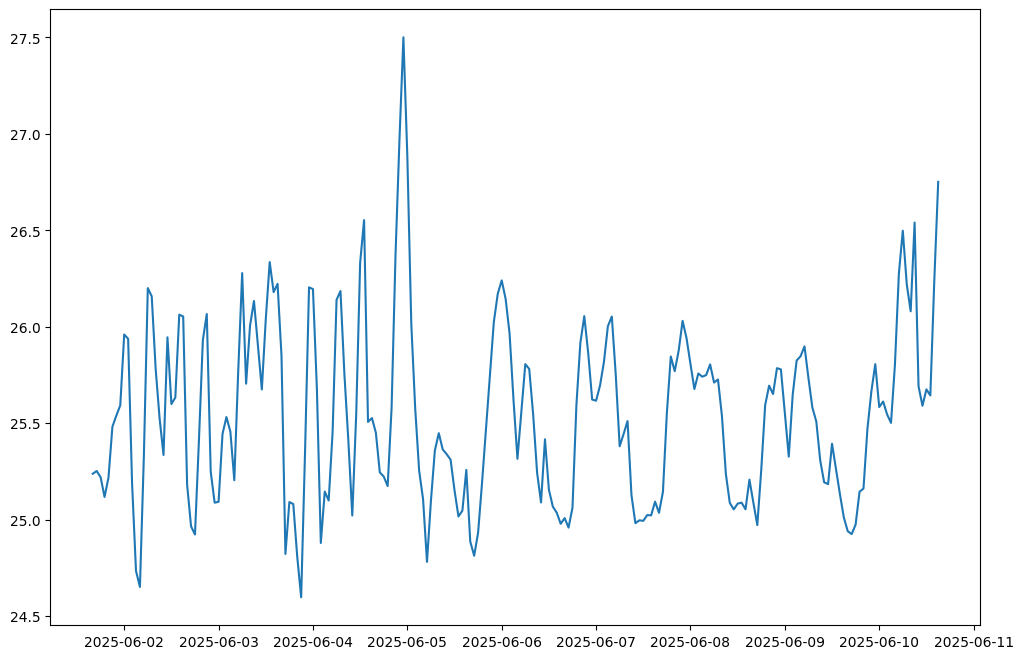

In [121]:
draw_plots(temperature_hourly, "temperature_reading")

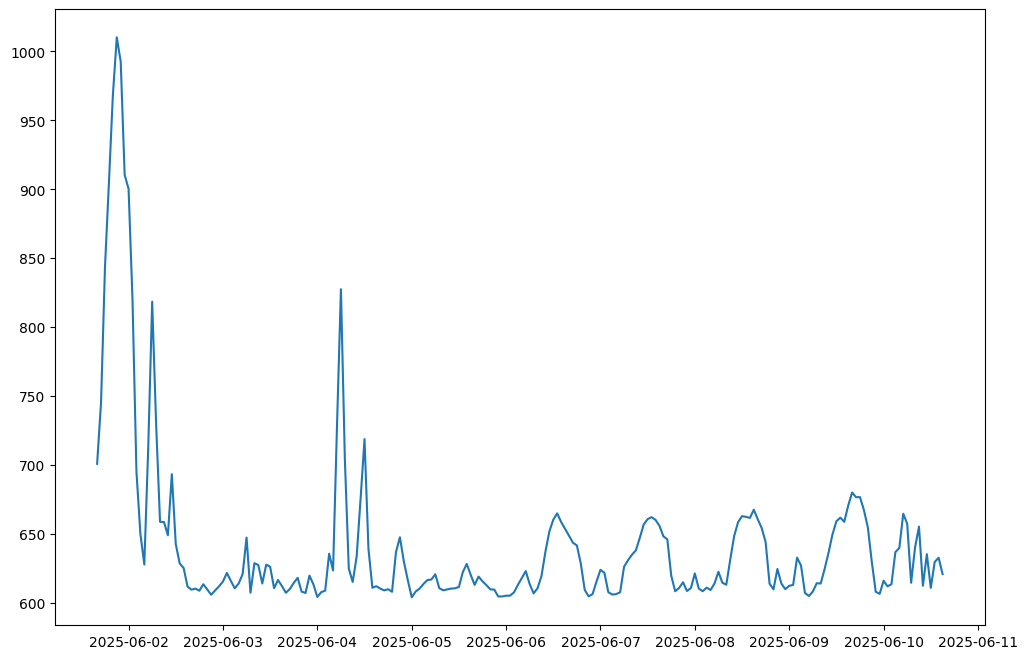

In [122]:
draw_plots(co2_hourly, "co2_reading")

In [21]:
models = [
    {
        "name": "SARIMAX",
        "call": SARIMAX,
        "params": {
            "order": (1, 1, 1),
            "seasonal_order": (1, 1, 1, 24)
        }
    },
    {
        "name": "LinearRegression",
        "call": LinearRegression,
        "params": {}
    },
    {
        "name": "XGBoost",
        "call": XGBRegressor,
        "params": {
            "n_estimators": 100,
            "max_depth": 3,
            "learning_rate": 0.1,
            "objective": "reg:squarederror"
        }
    },
    {
        "name": "LightGBM",
        "call": LGBMRegressor,
        "params": {
            "n_estimators": 100,
            "max_depth": 3,
            "learning_rate": 0.1
        }
    },
    {
        "name": "RandomForest",
        "call": RandomForestRegressor,
        "params": {
            "n_estimators": 100,
            "max_depth": 5
        }
    },
    {
        "name": "GradientBoosting",
        "call": GradientBoostingRegressor,
        "params": {
            "n_estimators": 100,
            "max_depth": 3,
            "learning_rate": 0.1
        }
    },
    {
        "name": "ARIMA",
        "call": ARIMA,
        "params": {
            "order": (1, 1, 1)
        }
    }
]

In [19]:
#split the data into training and testing sets
co2_train, co2_test = split_data(co2_hourly, 'co2_reading') 
temperature_train, temperature_test = split_data(temperature_hourly, 'temperature_reading')

In [146]:
# call the train_models function
co2_models = train_models(models, co2_train, 'co2_reading')
temperature_models = train_models(models, temperature_train, 'temperature_reading')

Preparing to train SARIMAX with parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 24)}
SARIMAX trained successfully.

Preparing to train LinearRegression with parameters: {}
LinearRegression trained successfully.

Preparing to train XGBoost with parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'objective': 'reg:squarederror'}
XGBoost trained successfully.

Preparing to train LightGBM with parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 1
[LightGBM] [Info] Start training from score 644.716422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [154]:
# call the evaluate_models function
co2_results = evaluate_models(co2_models, co2_test, 'co2_reading')
temperature_results = evaluate_models(temperature_models, temperature_test, 'temperature_reading')


Evaluating SARIMAX...
SARIMAX Mean Squared Error: 890.0904
SARIMAX R^2 Score: -0.7151
SARIMAX Mean Absolute Error: 23.5714
Evaluating LinearRegression...
LinearRegression Mean Absolute Error: 45.6504
LinearRegression R^2 Score: -4.2039
LinearRegression MSE: 2700.7238
Evaluating XGBoost...
XGBoost Mean Absolute Error: 82.5764
XGBoost R^2 Score: -35.5561
XGBoost MSE: 18971.9741
Evaluating LightGBM...
LightGBM Mean Absolute Error: 78.8633
LightGBM R^2 Score: -18.4823
LightGBM MSE: 10110.9893
Evaluating RandomForest...
RandomForest Mean Absolute Error: 84.1874
RandomForest R^2 Score: -35.8835
RandomForest MSE: 19141.8692
Evaluating GradientBoosting...
GradientBoosting Mean Absolute Error: 83.2559
GradientBoosting R^2 Score: -36.1102
GradientBoosting MSE: 19259.5074
Evaluating ARIMA...
ARIMA Mean Squared Error: 1229.8053
ARIMA R^2 Score: -1.3696
ARIMA Mean Absolute Error: 26.7539
Evaluation complete.
Evaluating SARIMAX...
SARIMAX Mean Squared Error: 0.1940
SARIMAX R^2 Score: -0.0947
SARIMAX

c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [155]:
co2_results

,Model,Parameters,MSE,MAE,R^2
0,SARIMAX,ar.L1 -0.089079 ma.L1 0.519796 ...,890.090375,23.571432,-0.715070
1,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",2700.723846,45.650357,-4.203887
2,XGBoost,"{'objective': 'reg:squarederror', 'base_score'...",18971.974107,82.576439,-35.556126
3,LightGBM,"{'boosting_type': 'gbdt', 'class_weight': None...",10110.989333,78.863325,-18.482348
4,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",19141.869213,84.187438,-35.883488
5,GradientBoosting,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",19259.507373,83.255898,-36.110159
6,ARIMA,ar.L1 -0.271391 ma.L1 0.720368 sigm...,1229.805302,26.753886,-1.369649


## that is really bad performance. I'll try other frequencies

In [13]:
def training_experimentation(resampling_frequency):

    co2 = co2_reading[['co2_reading']].resample(resampling_frequency).mean()
    temperature = temperature_reading[['temperature_reading']].resample(resampling_frequency).mean()

    #split the data into training and testing sets
    co2_train, co2_test = split_data(co2, 'co2_reading') 
    temperature_train, temperature_test = split_data(temperature, 'temperature_reading')

    co2_train = co2_train.dropna()
    temperature_train = temperature_train.dropna()
    co2_test = co2_test.dropna()
    temperature_test = temperature_test.dropna()

    # call the train_models function
    co2_models = train_models(models, co2_train, 'co2_reading')
    co2_results = evaluate_models(co2_models, co2_test, 'co2_reading')

    # call the evaluate_models function
    temperature_models = train_models(models, temperature_train, 'temperature_reading')
    temperature_results = evaluate_models(temperature_models, temperature_test, 'temperature_reading')

    co2_results.to_csv(f"./results/co2_results_{resampling_frequency}.csv", index=False)
    temperature_results.to_csv(f"./results/temperature_results_{resampling_frequency}.csv", index=False)

def run_training(frequency):
    print(f"Running training for frequency: {frequency}")
    training_experimentation(frequency)
    print(f"Training completed for frequency: {frequency}\n")

resampling_frequencies = ['1T', '5T', '30T', '1H', '6H', '12H', '1D']
'''
for frequency in resampling_frequencies:
    print(f"Training models with resampling frequency: {frequency}")
    p = Process(target=run_training, args=(frequency,))
    p.start()
    p.join()
    training_experimentation(frequency)
    print(f"Completed training for {frequency}\n")
'''

'\nfor frequency in resampling_frequencies:\n    print(f"Training models with resampling frequency: {frequency}")\n    p = Process(target=run_training, args=(frequency,))\n    p.start()\n    p.join()\n    training_experimentation(frequency)\n    print(f"Completed training for {frequency}\n")\n'

In [27]:
training_experimentation(resampling_frequencies[0])

C:\Users\ahmed\AppData\Local\Temp\ipykernel_25632\4202959059.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  co2 = co2_reading[['co2_reading']].resample(resampling_frequency).mean()
C:\Users\ahmed\AppData\Local\Temp\ipykernel_25632\4202959059.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  temperature = temperature_reading[['temperature_reading']].resample(resampling_frequency).mean()


Preparing to train SARIMAX with parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 24)}


c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MemoryError: Unable to allocate 187. MiB for an array with shape (51, 51, 9417) and data type float64

In [23]:
training_experimentation(resampling_frequencies[1])

C:\Users\ahmed\AppData\Local\Temp\ipykernel_3412\795641468.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  co2 = co2_reading[['co2_reading']].resample(resampling_frequency).mean()
C:\Users\ahmed\AppData\Local\Temp\ipykernel_3412\795641468.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  temperature = temperature_reading[['temperature_reading']].resample(resampling_frequency).mean()
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  

Preparing to train SARIMAX with parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 24)}
SARIMAX trained successfully.

Preparing to train LinearRegression with parameters: {}
LinearRegression trained successfully.

Preparing to train XGBoost with parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'objective': 'reg:squarederror'}
XGBoost trained successfully.

Preparing to train LightGBM with parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1973, number of used features: 1
[LightGBM] [Info] Start training from score 634.836559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA trained successfully.

All models trained successfully.
Evaluating SARIMAX...
SARIMAX Mean Squared Error: nan
SARIMAX R^2 Score: -3.1194
SARIMAX Mean Absolute Error: 38.1320
Evaluating LinearRegression...
Evaluating LinearRegression...
LinearRegression Mean Absolute Error: 23.7599
LinearRegression R^2 Score: -0.2747
LinearRegression MSE: 685.8893
Evaluating XGBoost...
Evaluating XGBoost...
XGBoost Mean Absolute Error: 47.0496
XGBoost R^2 Score: -7.9121
XGBoost MSE: 4795.5321
Evaluating LightGBM...
Evaluating LightGBM...
LightGBM Mean Absolute Error: 46.8712
LightGBM R^2 Score: -7.8479
LightGBM MSE: 4760.9551
Evaluating RandomForest...
Evaluating RandomForest...
RandomForest Mean Absolute Error: 47.6755
RandomForest R^2 Score: -8.4725
RandomForest MSE: 5097.0453
Evaluating GradientBoosting...
Evaluating GradientBoosting...
GradientBoosting Mean Absolute Error: 46.8692
GradientBoosting R^2 Score: -8.1860
GradientBoosting MSE: 4942.9341
Evaluating ARIMA...
ARIMA Mean Squared Error: 

c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\

SARIMAX trained successfully.

Preparing to train LinearRegression with parameters: {}
LinearRegression trained successfully.

Preparing to train XGBoost with parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'objective': 'reg:squarederror'}
XGBoost trained successfully.

Preparing to train LightGBM with parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1798, number of used features: 1
[LightGBM] [Info] Start training from score 25.475054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA trained successfully.

All models trained successfully.
Evaluating SARIMAX...
SARIMAX Mean Squared Error: nan
SARIMAX R^2 Score: -0.0383
SARIMAX Mean Absolute Error: 0.2562
Evaluating LinearRegression...
Evaluating LinearRegression...
LinearRegression Mean Absolute Error: 0.2563
LinearRegression R^2 Score: -0.0037
LinearRegression MSE: 0.0937
Evaluating XGBoost...
Evaluating XGBoost...
XGBoost Mean Absolute Error: 0.3083
XGBoost R^2 Score: -0.3998
XGBoost MSE: 0.1307
Evaluating LightGBM...
Evaluating LightGBM...
LightGBM Mean Absolute Error: 0.3087
LightGBM R^2 Score: -0.3844
LightGBM MSE: 0.1293
Evaluating RandomForest...
Evaluating RandomForest...
RandomForest Mean Absolute Error: 0.2595
RandomForest R^2 Score: -0.0045
RandomForest MSE: 0.0938
Evaluating GradientBoosting...
Evaluating GradientBoosting...
GradientBoosting Mean Absolute Error: 0.3128
GradientBoosting R^2 Score: -0.4249
GradientBoosting MSE: 0.1330
Evaluating ARIMA...
ARIMA Mean Squared Error: nan
ARIMA R^2 Score:

c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\

In [37]:
temperature_results_5T = pd.read_csv("./results/temperature_results_5T.csv")
temperature_results_5T

,Model,Parameters,MSE,MAE,R^2
0,SARIMAX,ar.L1 0.269287\nma.L1 0.402740\nar...,NaN,0.256210,-0.038319
1,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.093704,0.256261,-0.003661
2,XGBoost,"{'objective': 'reg:squarederror', 'base_score'...",0.130691,0.308285,-0.399829
3,LightGBM,"{'boosting_type': 'gbdt', 'class_weight': None...",0.129252,0.308675,-0.384422
4,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.093780,0.259459,-0.004482
5,GradientBoosting,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.133034,0.312811,-0.424929
6,ARIMA,ar.L1 0.276615\nma.L1 0.398491\nsigma2...,NaN,0.254196,-0.037140


In [28]:
co2_results_5T = pd.read_csv("./results/co2_results_5T.csv")

# Forecasting

In [43]:
import joblib
co2_model = joblib.load('./models/ARIMA_co2_reading_model.pkl')
temp_model = joblib.load('./models/ARIMA_temperature_reading_model.pkl')

In [49]:
n_steps = 30
co2_forecast = co2_model.forecast(steps=n_steps)
temp_forecast = temp_model.forecast(steps=n_steps)

last_timestamp = co2_test.index[-1]
future_index = pd.date_range(start=last_timestamp, periods=n_steps+1, freq='5T')[1:]
co2_forecast.index = future_index
temp_forecast.index = future_index

c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ahmed\miniconda3\envs\ds1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ahmed\AppData\Local\Temp\ipykernel_3412\621733643.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_index = pd.date_range(start=last_timestamp, periods=n_

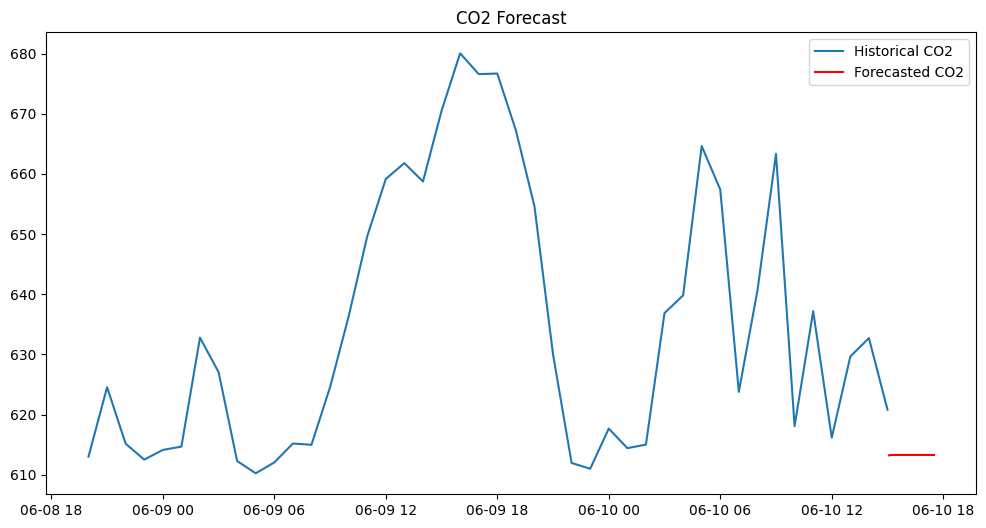

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(co2_test.index, co2_test['co2_reading'], label='Historical CO2')
plt.plot(co2_forecast.index, co2_forecast, label='Forecasted CO2', color='red')
plt.legend()
plt.title('CO2 Forecast')
plt.show()